### Import libraries

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
import os
import astropy.convolution as krn
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM

from deepeye_analysis_package.plotting import makeHeat

In [61]:
def compute_rms(samples):
    # Assuming `samples` is a list of tuples, each containing (x, y) coordinates
    deltas = np.diff(samples, axis=0)
    distances = np.linalg.norm(deltas, axis=1)
    rms = np.sqrt(np.mean(distances**2))
    return rms

### Preprocess files and make a dataframe

test_all file contains the results of a validation session. If calibration had to be repeated under the same participant name, then the results of the new validation are appended. Therefore, the test_all file may contain several validation datasets, each with each own header row. 


1. get_last_dataset()
    Extract the last dataset from the test_all file based on the header row. Participants had 3 attempts to get calibration <3 cm. Keep only the successful calibration dataset
2. scale_dot_postion()
    Scale pixels to standard dimensions. Calibration dots were presented as % display size in px. Convert pixels to cm. Assign each dot a unique label



In [62]:
def get_last_dataset(df):
   
    # Define numeric columns for conversion to number
    numeric_columns = ['numCalibDots', 'x', 'y', 'user_pred_px_x', 'user_pred_px_y', 'scrW_cm', 'resX', 'resY']    

    # Identify duplicate rows, which likely represent header rows
    header_indices = df.index[df.duplicated(keep=False)].tolist()

    # Extract the dataset after the last duplicated header, if any
    if header_indices:
        last_dataset = df.iloc[header_indices[-1]:].reset_index(drop=True)
        last_dataset.columns = last_dataset.iloc[0]  # Set column names from the first row after the header
        last_dataset = last_dataset[1:]  # Remove header row
    else:
        # If no additional headers, use the entire dataset with the first row as column names
        last_dataset = df
        last_dataset.columns = last_dataset.iloc[0]
        last_dataset = last_dataset[1:]

    # Reset column headers and convert specified columns to numeric, coercing errors
    last_dataset = last_dataset.reset_index(drop=True)
    last_dataset[numeric_columns] = last_dataset[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Drop rows where 'numCalibDots' is NaN and convert to integer
    last_dataset.dropna(subset=['numCalibDots'], inplace=True)
    last_dataset['numCalibDots'] = last_dataset['numCalibDots'].astype(int)
    

    # Calculate Euclidean distance in pixels and centimeters
    last_dataset['eucl_dist_px_orig'] = np.linalg.norm(
        last_dataset[['x', 'y']].to_numpy() - last_dataset[['user_pred_px_x', 'user_pred_px_y']].to_numpy(), axis=1
    )
    last_dataset['scale_cm_in_px'] = last_dataset['scrW_cm'] / last_dataset['resX']
    last_dataset['eucl_dist_cm_orig'] = last_dataset['eucl_dist_px_orig'] * last_dataset['scale_cm_in_px']

    return last_dataset

In [63]:
def scale_dot_position(last_dataset, fn, target_resX=None, target_resY=None):

    # Define target resolution for scaling not provided, take the first resolution in the dataset
    if not target_resX or not target_resY:
        target_resX, target_resY = last_dataset['resX'].iloc[0], last_dataset['resY'].iloc[0]

    # Scale coordinates
    last_dataset['user_pred_px_x_scaled'] = last_dataset['user_pred_px_x'] / last_dataset['resX'] * target_resX
    last_dataset['user_pred_px_y_scaled'] = last_dataset['user_pred_px_y'] / last_dataset['resY'] * target_resY
    last_dataset['x_scaled'] = np.round(last_dataset['x'] / last_dataset['resX'] * target_resX)
    last_dataset['y_scaled'] = np.round(last_dataset['y'] / last_dataset['resY'] * target_resY)

    # Add subject identifier
    last_dataset['subj_nr'] = fn

    # Identify unique dot positions
    _, indices = np.unique(last_dataset[['x_scaled', 'y_scaled']], axis=0, return_inverse=True)
    last_dataset['unique_dot'] = indices

    return last_dataset


In [64]:
# Path to data folders
# path_to_folders = 'D:/Dropbox/DeepEye_Pilots/VBL_Exp1/data/approved/data'
path_to_folders = 'C:/Users/aby600/Dropbox/DeepEye_Pilots/VBL_Exp1/data/approved/data'

# Get all folder names
folder_names = os.listdir(path_to_folders)

# List to accumulate datasets across subjects
pp_list = []

# Define target resolution, since datasets may have different screen resolutions
TARG_RES = True
if TARG_RES:
    target_resX, target_resY = 1920, 1080
else:
    target_resX, target_resY = None, None

for fn in folder_names:
    path = os.path.join(path_to_folders, fn, f"{fn}_test_all.csv")
    
    try:
        # Read the file into a DataFrame without assuming headers
        df = pd.read_csv(path, header=None)
    except Exception:
        continue

    df = get_last_dataset(df)
    df = scale_dot_position(df, fn, target_resX, target_resY)

    # Identify unique dot positions
    unique_dots = df[['x_scaled', 'y_scaled']].drop_duplicates()

    # Filter out participants if they have fewer unique dots than the number in 'numCalibDots'
    required_dots = df['numCalibDots'].iloc[0]
    if len(unique_dots) < required_dots:
        print(f"Skipping participant {fn} with fewer unique dots ({len(unique_dots)}) than required ({required_dots})")
        continue  # Skip this participant if they have fewer unique dots

    # Append the cleaned dataset to the list
    pp_list.append(df)

# Concatenate all subject data into a single DataFrame
all_df = pd.concat(pp_list, ignore_index=True)

Skipping participant 2024_02_19_10_25_11 with fewer unique dots (6) than required (9)
Skipping participant 2024_03_11_14_14_36 with fewer unique dots (8) than required (9)


## Plot heatmap across all subjects

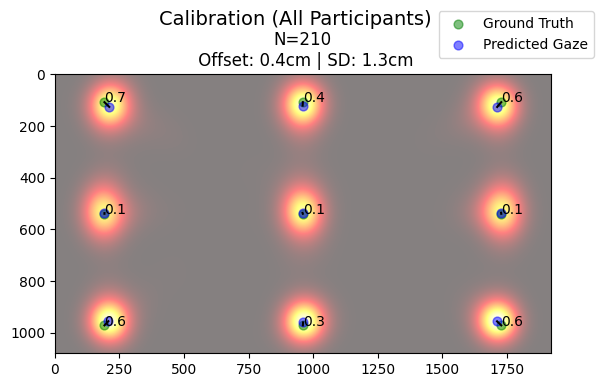

In [65]:
def plot_heatmap(df):
    # Generate heatmap for all gaze points
    heatmap = makeHeat([target_resX, target_resY], df['user_pred_px_x_scaled'].values, df['user_pred_px_y_scaled'].values)
    
    # Calculate median gaze predictions and ground truth per dot
    median_pred = df.groupby('unique_dot')[['user_pred_px_x_scaled', 'user_pred_px_y_scaled']].median()
    median_pred.columns = ['median_pred_x', 'median_pred_y']
    
    true_pos = df.groupby('unique_dot')[['x_scaled', 'y_scaled']].mean()
    
    # Calculate offset between median gaze predictions and ground truth, then convert to cm
    offset_px = np.linalg.norm(median_pred.values - true_pos.values, axis=1)
    offset_cm = offset_px * df['scale_cm_in_px'].iloc[0]
    
    # Calculate Euclidean distance from each gaze point to the median prediction for each dot
    df = df.merge(median_pred, on='unique_dot', how='left')

    df['eucl_dist_gaze_to_median_px'] = np.linalg.norm(
        df[['user_pred_px_x_scaled', 'user_pred_px_y_scaled']].values - df[['median_pred_x', 'median_pred_y']].values,
        axis=1
    )    
    
    # Calculate the mean Euclidean distance per dot and convert to cm for standard deviation (SD)
    SD_px = df.groupby('unique_dot')['eucl_dist_gaze_to_median_px'].mean()
    SD_cm = SD_px * df['scale_cm_in_px'].iloc[0]

    # Plot heatmap and ground truth vs. predicted gaze points
    plt.figure()
    plt.imshow(heatmap, cmap=cm.hot, extent=[0, target_resX, target_resY, 0], alpha=0.5, aspect='equal')
    
    # Plot ground truth positions (green) and median predicted gaze (blue)
    plt.scatter(true_pos['x_scaled'], true_pos['y_scaled'], c='g', s=40, alpha=0.5, label='Ground Truth')
    plt.scatter(median_pred['median_pred_x'], median_pred['median_pred_y'], c='b', s=40, alpha=0.5, label='Predicted Gaze')
    
    # Draw lines between ground truth and predictions for visualizing offsets
    plt.plot([median_pred['median_pred_x'], true_pos['x_scaled']], [median_pred['median_pred_y'], true_pos['y_scaled']], c='black')
            
    # Title and statistics in the legend
    plt.title(f'N={df["subj_nr"].nunique()}\n Offset: {offset_cm.mean():.1f}cm | SD: {SD_cm.mean():.1f}cm', fontsize=12)
    
    # Annotate offset values near each ground truth dot position
    for (x, y, e) in zip(true_pos['x_scaled'], true_pos['y_scaled'], offset_cm.round(1)):
        plt.text(x, y, str(e), fontsize=10, color='black')
    
    # Add legend and final touches
    plt.suptitle('Calibration (All Participants)', fontsize=14)
    plt.subplots_adjust(top=1.0)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.25))
    
    # Show the plot
    plt.show()

# Call the function with the dataframe
plot_heatmap(all_df)


## Calculate and plot offsets and SD per condition per subject

1. Offset - euclidean distance from the median gaze prediction per each dot to the ground truth
2. SD - mean of euclidean distances from each gaze prediction to the median gaze prediction for each dot
3. RMS - sample to sample euclidean distance for each gaze positions for each dot

In [66]:
# Prepare summary data across subjects
summary_data = []

# Calculate metrics for each subject and unique dot
for _, group in all_df.groupby(['subj_nr', 'unique_dot']):
    # Compute median gaze for each unique dot
    median_x = group['user_pred_px_x_scaled'].median()
    median_y = group['user_pred_px_y_scaled'].median()
    
    # Sort by timestamp to ensure temporal order
    group.sort_values('frameNr', inplace=True)    

    # Compute Euclidean distances
    gaze_coords = group[['user_pred_px_x_scaled', 'user_pred_px_y_scaled']].to_numpy()
    median_coords = np.array([median_x, median_y])
    
    # Distance from gaze samples to median gaze (precision)
    group['eucl_dist_gaze_to_median_px'] = np.linalg.norm(gaze_coords - median_coords, axis=1)
    group['eucl_dist_gaze_to_median_cm'] = group['eucl_dist_gaze_to_median_px'] * all_df['scale_cm_in_px'].iloc[0]
    
    # Offset from median gaze to ground truth (accuracy)
    ground_truth_coords = group[['x_scaled', 'y_scaled']].to_numpy()
    group['median_offset_px'] = np.linalg.norm(median_coords - ground_truth_coords, axis=1)
    group['median_offset_cm'] = group['median_offset_px'] * all_df['scale_cm_in_px'].iloc[0]

    # RMS error sample-to-sample (temproal precision)
    group['rms_error_px'] = compute_rms(gaze_coords)
    group['rms_error_cm'] = group['rms_error_px'] * all_df['scale_cm_in_px'].iloc[0]
    
    summary_data.append(group)

# Combine data across all subjects and calculate mean precision (SD) and accuracy (offset)
summary_df = pd.concat(summary_data)

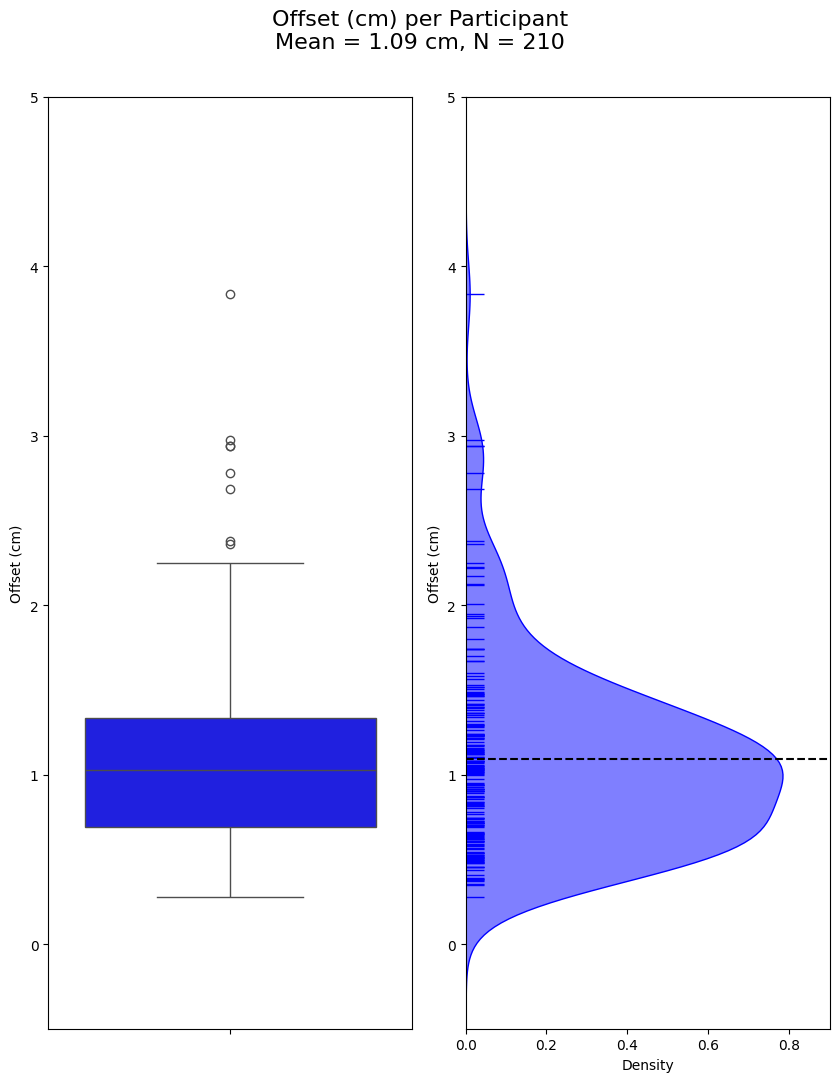

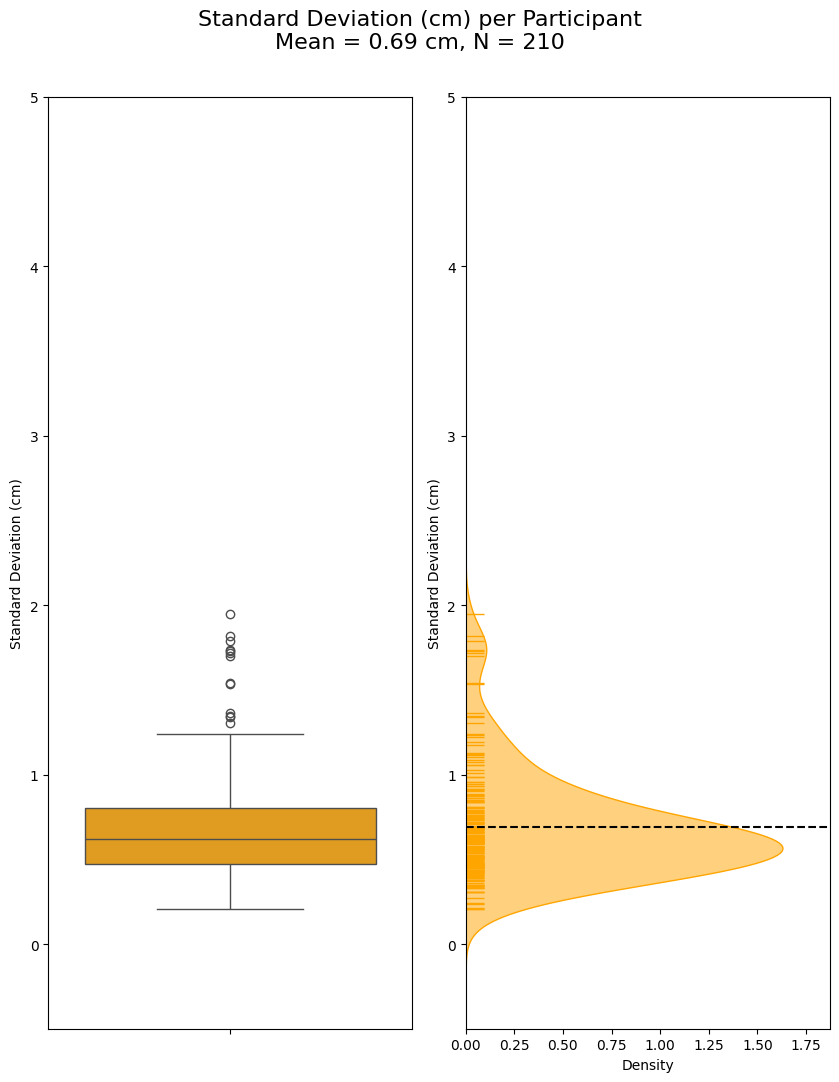

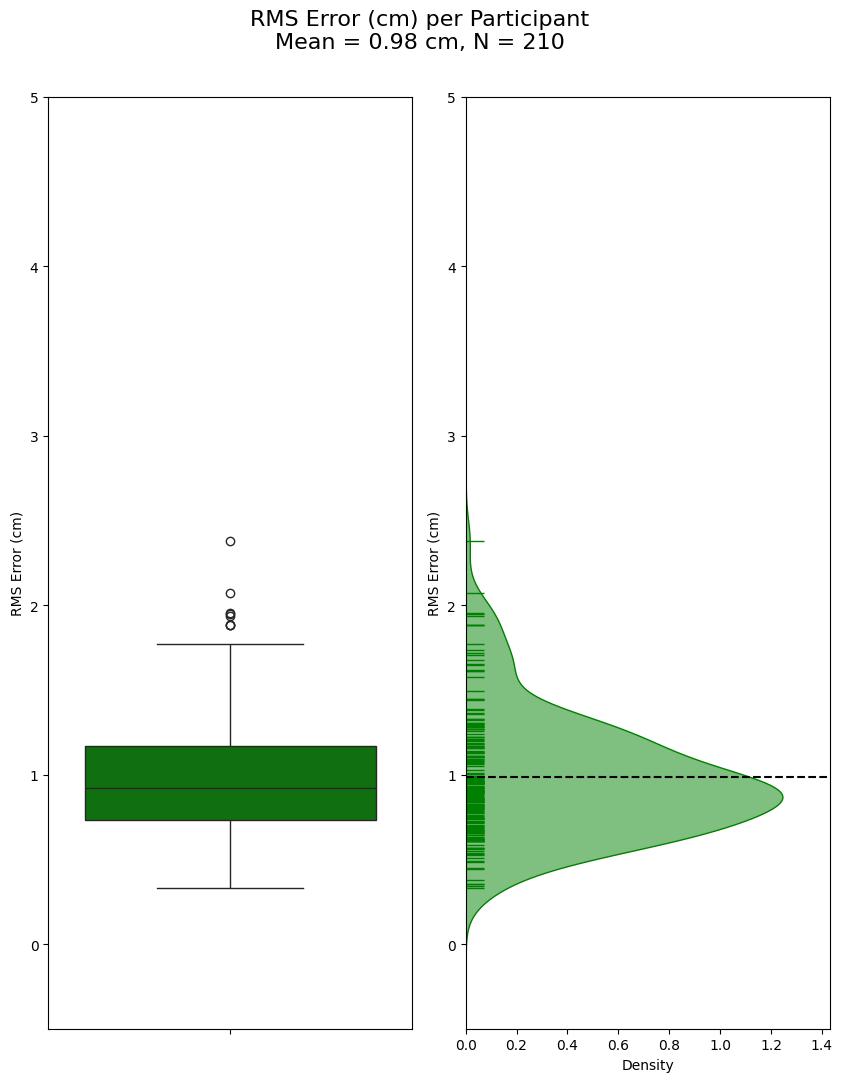

In [67]:
def plot_measurement_per_participant(df, measurement='median_offset_cm', name='', color='b'):
    fig, axes = plt.subplots(1, 2, figsize=(8.5, 11))
    
    measurement_pp = df.groupby('subj_nr', as_index=False)[measurement].mean()
    mean_value = measurement_pp[measurement].mean()
    
    # KDE Plot with individual data points (rug plot)
    sns.kdeplot(y=measurement_pp[measurement], ax=axes[1], fill=True, alpha=0.5, color=color)
    sns.rugplot(y=measurement_pp[measurement], ax=axes[1], height=0.05, color=color)
    axes[1].axhline(mean_value, color='k', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')
    
    # Boxplot
    sns.boxplot(y=measurement_pp[measurement], ax=axes[0], color=color)
    
    # Set consistent y-axis limits and labels
    for ax in axes:
        ax.set_ylim(-0.5, 5)
        ax.set_ylabel(name)
        
    fig.suptitle(f'{name} per Participant\nMean = {mean_value:.2f} cm, N = {df.subj_nr.nunique()}', fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    
    # Uncomment the line below to save the plot
    # fig.savefig(f'{name}_summary.jpg', dpi=1000)

summary_df_per_pp= summary_df.groupby(['subj_nr'])[['median_offset_cm', 'eucl_dist_gaze_to_median_cm', 'rms_error_cm']].mean().reset_index()

plot_measurement_per_participant(summary_df_per_pp, measurement='median_offset_cm', name='Offset (cm)', color='b')
plot_measurement_per_participant(summary_df_per_pp, measurement='eucl_dist_gaze_to_median_cm', name='Standard Deviation (cm)', color='orange')
plot_measurement_per_participant(summary_df_per_pp, measurement='rms_error_cm', name='RMS Error (cm)', color='g')

In [68]:
# Participant descriptive statistics (gaze samples per participant)
descr_stats = summary_df.groupby(['subj_nr', 'pp_id'])['unique_dot'].count().reset_index()
print(f'Descriptive Stats:\n {descr_stats}')

Descriptive Stats:
                  subj_nr    pp_id  unique_dot
0    2024_02_19_08_03_20    28861         400
1    2024_02_19_08_03_44    32041         387
2    2024_02_19_08_04_13    31795         395
3    2024_02_19_08_14_12    29509         395
4    2024_02_19_08_43_42    36313         388
..                   ...      ...         ...
205  2024_03_14_10_26_10    32224         407
206  2024_03_15_08_14_16    36958         404
207  2024_03_15_08_42_43    28672         397
208  2024_03_15_08_53_54    30790         401
209  2024_03_15_11_15_54  31192.0         397

[210 rows x 3 columns]


In [69]:
# Participant descriptive statistics (gaze samples per participant)
descr_stats2 = summary_df.groupby(['subj_nr','unique_dot'])['median_offset_cm'].count().reset_index()
descr_stats3 = descr_stats2.groupby(['subj_nr']).unique_dot.count().reset_index()
print(f'Mean unique dots:\n {descr_stats3}')

Mean unique dots:
                  subj_nr  unique_dot
0    2024_02_19_08_03_20           9
1    2024_02_19_08_03_44           9
2    2024_02_19_08_04_13           9
3    2024_02_19_08_14_12           9
4    2024_02_19_08_43_42           9
..                   ...         ...
205  2024_03_14_10_26_10           9
206  2024_03_15_08_14_16           9
207  2024_03_15_08_42_43           9
208  2024_03_15_08_53_54           9
209  2024_03_15_11_15_54           9

[210 rows x 2 columns]


## Plot offset per dot per subject

Maximum value: 8.337335371624011
Index of maximum value: 477


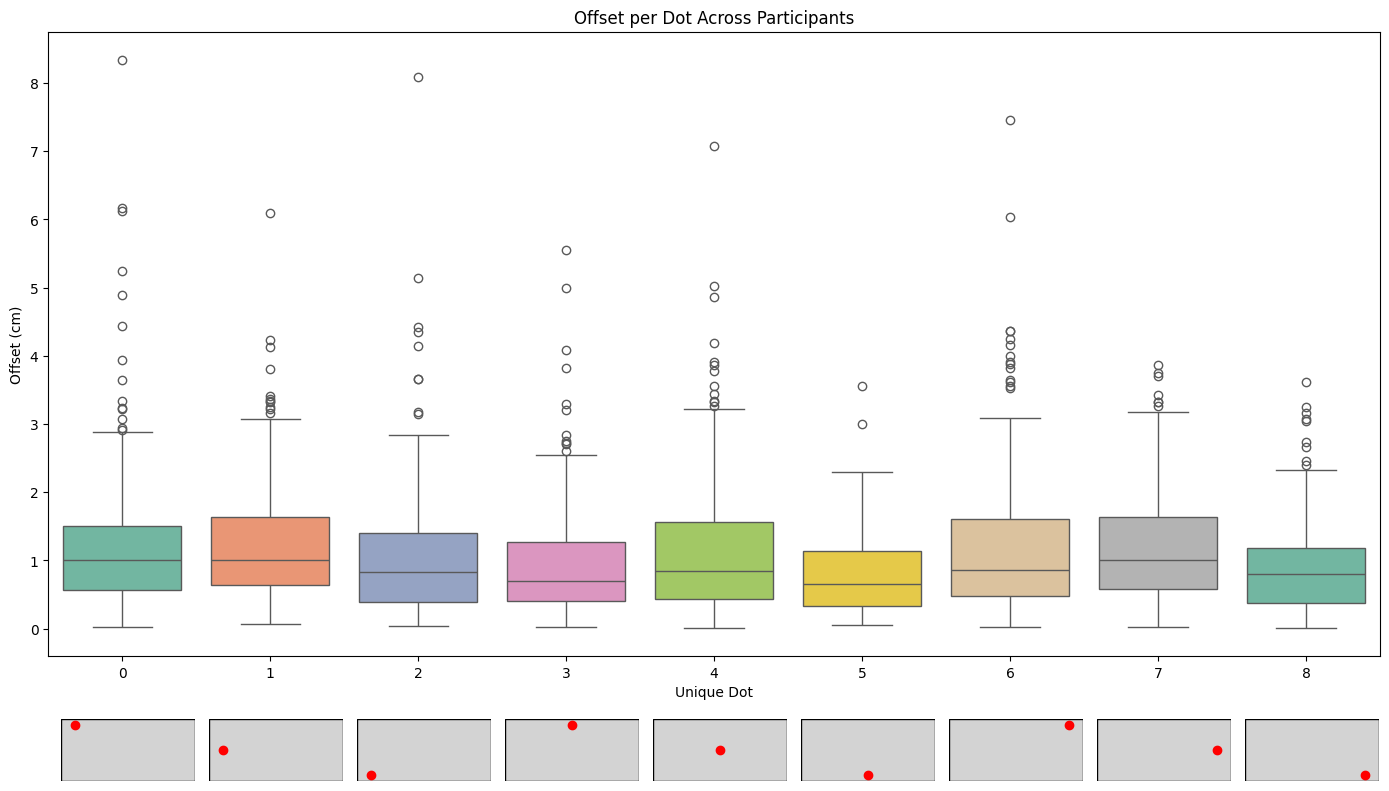

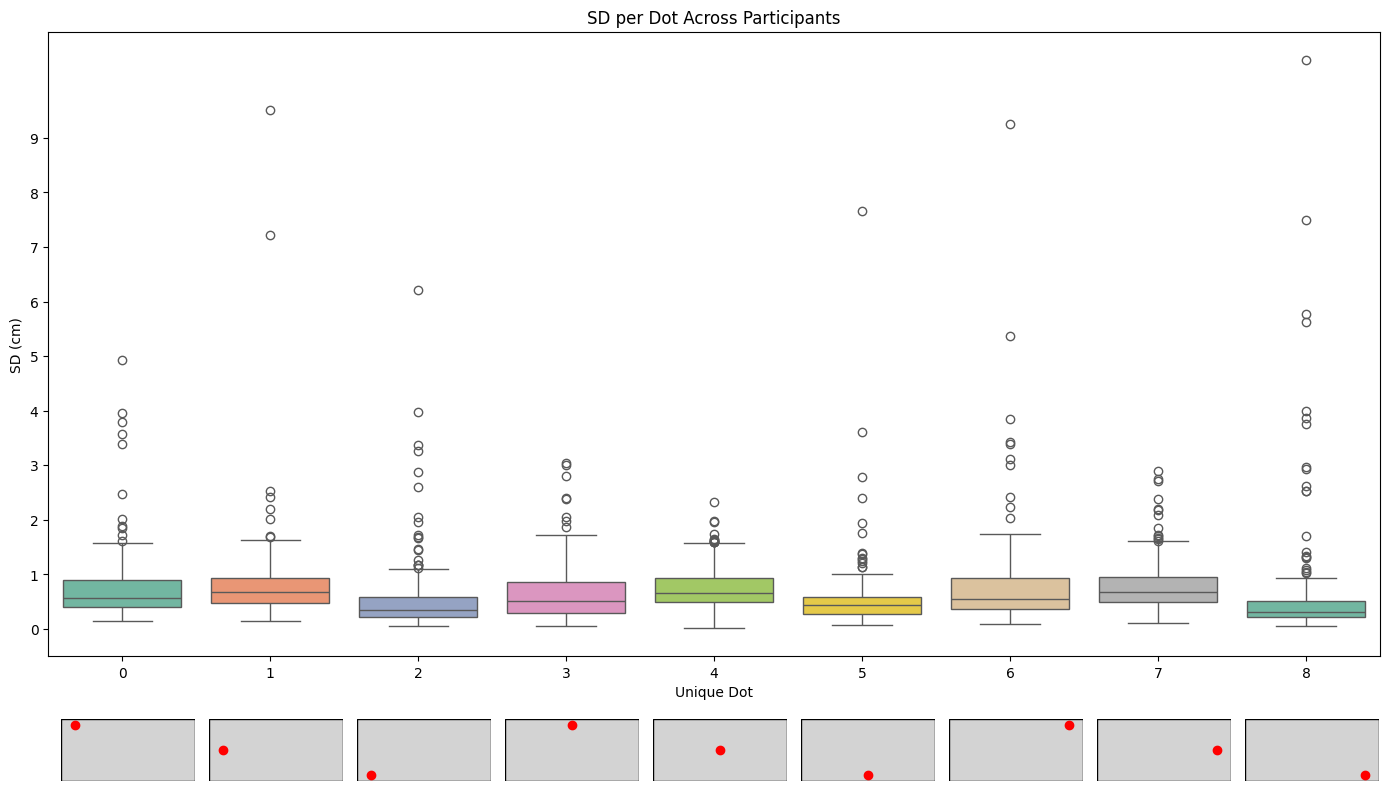

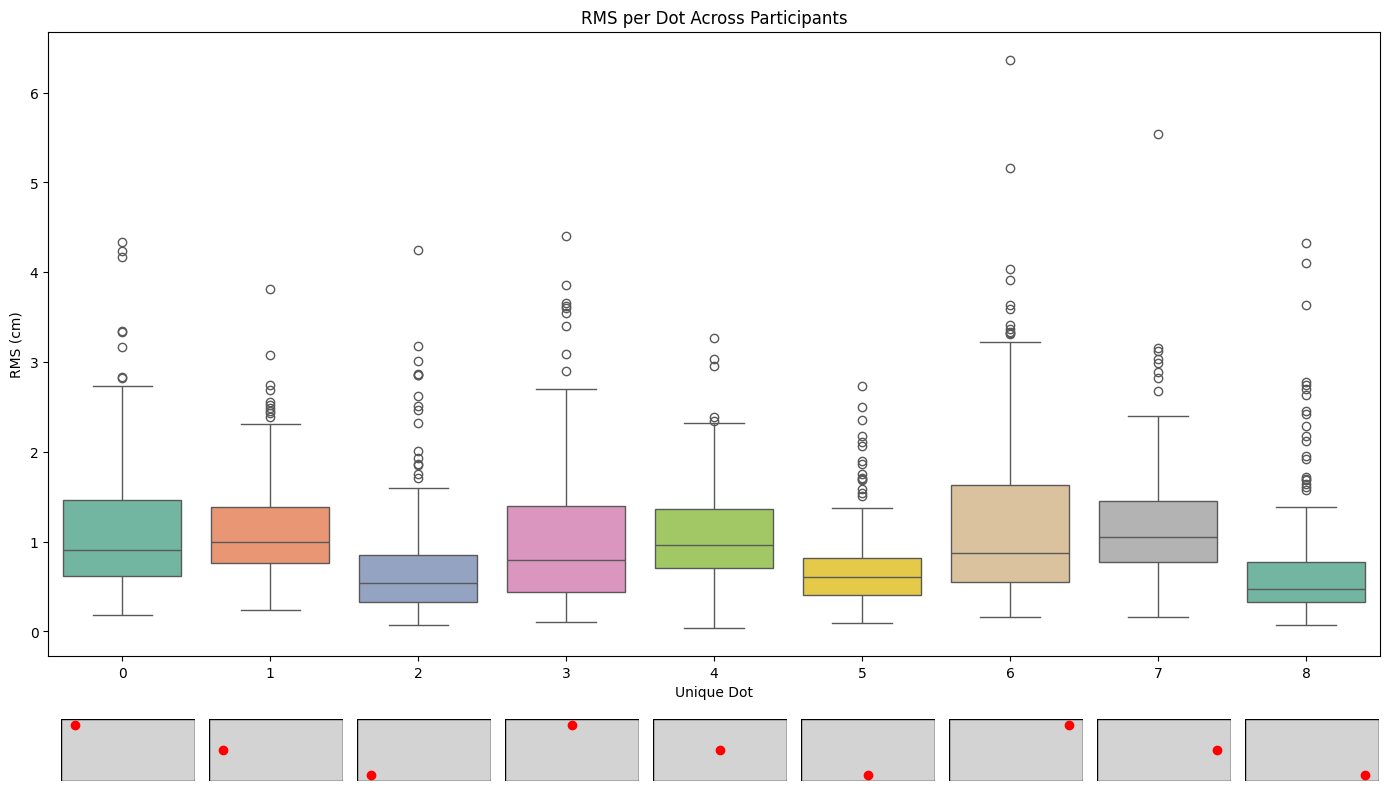

In [70]:
def plot_offset_per_dot_with_positions(summary_df, measurement='Offset', screen_width=192, screen_height=1080):
    """
    Plots offset across participants for each dot with a small illustration under each box plot
    indicating each dot's position on the screen.
    
    Parameters:
    - summary_df (pd.DataFrame): Dataframe containing offset data for each dot and participant.    
    - screen_width (int): Width of the screen (for relative positioning).
    - screen_height (int): Height of the screen (for relative positioning).
    """
    
        
    # Set up the main figure and the box plot
    plt.figure(figsize=(14, 8))
    main_ax = plt.gca()  # Get current axes for main plot    
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Set specific positions for the tick marks

    if measurement == 'Offset':
        sns.boxplot(x='unique_dot', y='median_offset_cm', data=summary_df, hue='unique_dot', palette="Set2", ax=main_ax, legend=False)
    elif measurement == 'SD':
        sns.boxplot(x='unique_dot', y='eucl_dist_gaze_to_median_cm', data=summary_df, hue='unique_dot', palette="Set2", ax=main_ax, legend=False)
    elif measurement == 'RMS':
        sns.boxplot(x='unique_dot', y='rms_error_cm', data=summary_df, hue='unique_dot', palette="Set2", ax=main_ax, legend=False)

    
    # Set labels for main plot
    main_ax.set_xlabel('Unique Dot')
    main_ax.set_ylabel(f'{measurement} (cm)')
    main_ax.set_title(f'{measurement} per Dot Across Participants')
    
    # Draw a small position illustration below each unique dot box
    unique_dots = summary_df['unique_dot'].unique()
    for i, dot in enumerate(unique_dots):
        # Filter the dataframe for the current dot
        dot_data = summary_df[summary_df['unique_dot'] == dot]
        
        # Average dot position on screen (x_scaled and y_scaled)
        x_avg = dot_data['x_scaled'].mean()
        y_avg = dot_data['y_scaled'].mean()
        
        # Add inset axis under the box plot for this dot
        inset_ax = main_ax.inset_axes([i / len(unique_dots) + 0.01, -0.2, 0.9 / len(unique_dots), 0.1])
        
        # Draw the rectangle representing the screen
        inset_ax.add_patch(patches.Rectangle((0, 0), screen_width, screen_height, edgecolor='black', facecolor='lightgray'))
        
        # Plot the dot’s relative position
        inset_ax.plot(x_avg/1920 *screen_width, y_avg/1080 * screen_height, 'ro')
        
        # Set axis limits and remove ticks for the inset plot
        inset_ax.set_xlim(0, screen_width)
        inset_ax.set_ylim(0, screen_height)
        inset_ax.invert_yaxis()  # Invert the y-axis
        inset_ax.axis('off')  # Hide axes for clarity

    # Adjust layout
    plt.tight_layout()
    plt.show()

summary_df_per_dot= summary_df.groupby(['subj_nr','unique_dot', 'x_scaled', 'y_scaled'])[['median_offset_cm', 'eucl_dist_gaze_to_median_cm', 'rms_error_cm']].mean().reset_index()
max_value = summary_df_per_dot['median_offset_cm'].max()
max_index = summary_df_per_dot['median_offset_cm'].idxmax()
print("Maximum value:", max_value)
print("Index of maximum value:", max_index)

plot_offset_per_dot_with_positions(summary_df_per_dot, measurement='Offset')
plot_offset_per_dot_with_positions(summary_df_per_dot, measurement='SD')
plot_offset_per_dot_with_positions(summary_df_per_dot, measurement='RMS')

In [71]:
# Group dots by the column and row they are in
_, col_indices = np.unique(summary_df_per_dot[['x_scaled']], axis=0, return_inverse=True)
summary_df_per_dot['unique_column'] = col_indices
_, row_indices = np.unique(summary_df_per_dot[['y_scaled']], axis=0, return_inverse=True)
summary_df_per_dot['unique_row'] = row_indices


In [72]:
dot_rows = summary_df_per_dot.groupby(['subj_nr', 'unique_row'], as_index=False)['median_offset_cm'].mean()

print(dot_rows.groupby(['unique_row']).median_offset_cm.mean())


# Perform the repeated measures ANOVA
anova = AnovaRM(dot_rows, depvar='median_offset_cm', subject='subj_nr', within=['unique_row']).fit()

# Display the ANOVA table
print(anova.summary())

dot_columns = summary_df_per_dot.groupby(['subj_nr', 'unique_column'], as_index=False)['median_offset_cm'].mean()   

print(dot_columns.groupby(['unique_column']).median_offset_cm.mean())

# Perform the repeated measures ANOVA
anova = AnovaRM(dot_columns, depvar='median_offset_cm', subject='subj_nr', within=['unique_column']).fit()

# Display the ANOVA table
print(anova.summary())

import pingouin as pg

# Perform pairwise comparisons with Bonferroni correction
pairwise_results = pg.pairwise_tests(dv='median_offset_cm', within='unique_row', subject='subj_nr', 
                                      data=dot_rows, padjust='bonf')

# Display the results
print(pairwise_results)



unique_row
0    1.142218
1    1.199262
2    0.933295
Name: median_offset_cm, dtype: float64
                  Anova
           F Value Num DF  Den DF  Pr > F
-----------------------------------------
unique_row 17.2155 2.0000 418.0000 0.0000

unique_column
0    1.206647
1    0.967031
2    1.101096
Name: median_offset_cm, dtype: float64
                   Anova
              F Value Num DF  Den DF  Pr > F
--------------------------------------------
unique_column 12.1965 2.0000 418.0000 0.0000

     Contrast  A  B  Paired  Parametric         T    dof alternative  \
0  unique_row  0  1    True        True -1.088282  209.0   two-sided   
1  unique_row  0  2    True        True  4.468089  209.0   two-sided   
2  unique_row  1  2    True        True  6.102384  209.0   two-sided   

          p-unc        p-corr p-adjust       BF10    hedges  
0  2.777239e-01  8.331717e-01     bonf      0.138 -0.078105  
1  1.292333e-05  3.877000e-05     bonf    942.834  0.298049  
2  5.001871e-09  1.500561e

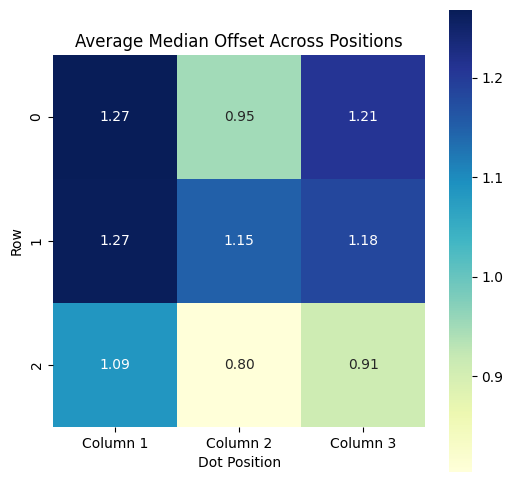

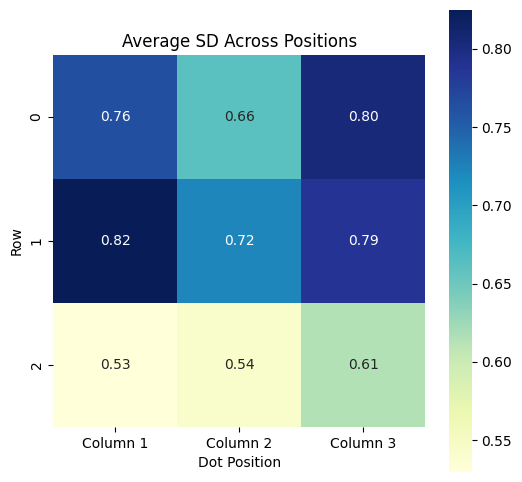

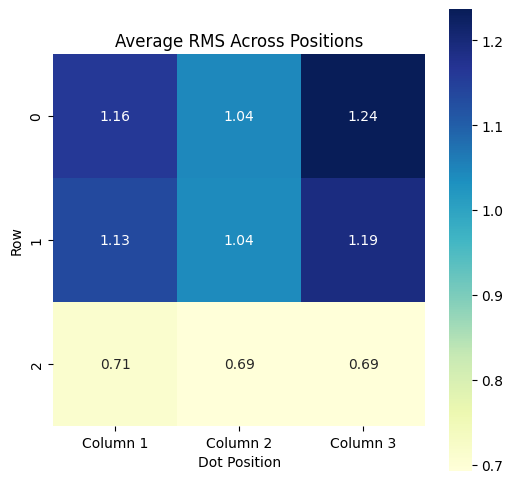

In [73]:
def plot_matrix(df, measurement='median_offset_cm', title='Average Median Offset Across Positions'):

    # Calculate the average median offset for each dot across all subjects
    average_per_dot = df.groupby('unique_dot', as_index=False)[measurement].mean()

    ## Create a DataFrame to reflect the 3-row layout
    dot_matrix = pd.DataFrame({
        'Column 1': average_per_dot[measurement][0:3].values,
        'Column 2': average_per_dot[measurement][3:6].values,
        'Column 3': average_per_dot[measurement][6:9].values
    })

    # Plot the heatmap with the layout in three rows
    plt.figure(figsize=(6, 6))
    sns.heatmap(dot_matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': ''}, square=True)

    # Set the title and labels
    plt.title(title)
    plt.xlabel('Dot Position')
    plt.ylabel('Row')
    plt.show()

plot_matrix(summary_df_per_dot, measurement='median_offset_cm', title='Average Median Offset Across Positions')
plot_matrix(summary_df_per_dot, measurement='eucl_dist_gaze_to_median_cm', title='Average SD Across Positions')
plot_matrix(summary_df_per_dot, measurement='rms_error_cm', title='Average RMS Across Positions')